In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import aparent.visualization as vis

from aparent.predictor import *

import urllib
import urllib.request
import pickle
from time import sleep


Using TensorFlow backend.


In [2]:
#Tissue types to compile data for

tissue_groups = [
    ['Testis'],
    ['Ovary'],
    ['Cells_EBV-transformed_lymphocytes'],
    [
        'Brain_Amygdala',
        'Brain_Anterior_cingulate_cortex_BA24',
        'Brain_Caudate_basal_ganglia',
        'Brain_Cerebellar_Hemisphere',
        'Brain_Cortex',
        'Brain_Frontal_Cortex_BA9',
        'Brain_Hippocampus',
        'Brain_Hypothalamus',
        'Brain_Nucleus_accumbens_basal_ganglia',
        'Brain_Putamen_basal_ganglia',
        'Brain_Spinal_cord_cervical_c-1',
        'Brain_Substantia_nigra',
    ],
]

basic_tissues = [
    'Testis',
    'Ovary',
    'Cells_EBV-transformed_lymphocytes',
    'Brain_Amygdala',
    'Brain_Anterior_cingulate_cortex_BA24',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
    'Brain_Hippocampus',
    'Brain_Hypothalamus',
    'Brain_Nucleus_accumbens_basal_ganglia',
    'Brain_Putamen_basal_ganglia',
    'Brain_Spinal_cord_cervical_c-1',
    'Brain_Substantia_nigra',
]

basic_tissue_dict = {t : i for i, t in enumerate(basic_tissues)}

tissue_scalers = [
    None,
    'human_convnet_16_16_no_dense_linear_leslie_hek293_testis_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_ovary_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_blcl_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
]

tissue_scales = [
    0.,
    0.05,
    0.05,
    0.05,
    0.05,
]

correct_tissue_scalers = [
    'human_convnet_16_16_no_dense_linear_leslie_hek293_testis_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_ovary_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_blcl_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
    'human_convnet_16_16_no_dense_linear_leslie_hek293_brain_all_cuts_ensemble',
]


In [3]:

version_suffix = '_aparent_v8'


In [4]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import average_precision_score
import random

spearman_rs = np.zeros((len(basic_tissues), len(tissue_scalers)))

correct_spearman_rs = []

blacklist_ids = [
    'chr11_121293731_G_A_b38',
    'chr9_32454350_T_A_b38',
    'chr6_106667519_A_G_b38',
    'chr10_16513432_A_T_b38',
    'chr1_246767817_A_G_b38',
    'chr18_80061444_C_T_b38',
    'chr2_216502547_G_A_b38',
    'chr10_104267428_A_T_b38',
    'chr2_55329080_C_T_b38',
    'chr17_76699948_A_T_b38',
    'chr2_201535513_T_C_b38',
    'chr5_126543217_A_T_b38',
    'chr5_126543216_C_A_b38',
    'chr19_47384225_T_C_b38',
]

source_df = pd.read_csv("predictions/apa_gtex_data/aparent_all_libs_resnet_no_clinvar_wt_ep_5_v8_nonlead_predictions_pred_df.csv", sep='\t')
source_df = source_df.loc[source_df['tissue_type'].isin(basic_tissues)].copy().reset_index(drop=True)

for tissue_ix, tissue_type in enumerate(basic_tissues) :
    
    for scaler_ix in range(len(tissue_scalers)) :

        snp_pred_df = source_df.copy()
        snp_pred_df = snp_pred_df.query("tissue_type == '" + tissue_type + "'").copy().reset_index(drop=True)
        
        snp_pred_df = snp_pred_df.query("p_val < 1e-20").copy().reset_index(drop=True)
        
        snp_pred_df['join_id'] = snp_pred_df['gene_id'] + "_" + snp_pred_df['snp_id'] + "_" + snp_pred_df['transcript_id']
    
        snp_pred_df['cis_snp'] = snp_pred_df['snp_distance'].apply(lambda x: 1. if x < 150 else -1.)
        
        snp_pred_df['snp_pos'] = snp_pred_df['rel_snp_pos'] - 105
    
        snp_pred_df.loc[snp_pred_df['snp_id'].isin(blacklist_ids), 'cis_snp'] = -1 * snp_pred_df[snp_pred_df['snp_id'].isin(blacklist_ids)]['cis_snp']

        if tissue_scalers[scaler_ix] is not None :
            
            ensemble_df = pd.read_csv("predictions/apa_gtex_data/" + tissue_scalers[scaler_ix] + "_v8_nonlead_predictions_pred_df.csv", sep='\t')
            
            snp_pred_df['join_id'] = snp_pred_df['gene_id'] + "_" + snp_pred_df['snp_id'] + "_" + snp_pred_df['transcript_id']
            ensemble_df['join_id'] = ensemble_df['gene_id'] + "_" + ensemble_df['snp_id'] + "_" + ensemble_df['transcript_id']
            
            snp_pred_df = snp_pred_df.join(ensemble_df[['join_id', 'ref_tissue_score_1', 'ref_tissue_score_2', 'var_tissue_score_1', 'var_tissue_score_2']].set_index('join_id'), on='join_id', how='inner').copy().reset_index(drop=True)

        else :
            snp_pred_df['ref_tissue_score_1'] = 0.
            snp_pred_df['ref_tissue_score_2'] = 0.
            snp_pred_df['var_tissue_score_1'] = 0.
            snp_pred_df['var_tissue_score_2'] = 0.

        snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] + tissue_scales[scaler_ix] * (snp_pred_df['var_tissue_score_2'] - snp_pred_df['var_tissue_score_1'])

        #PDUI
        snp_pred_df['mean_PDUI_pred_var'] = 1. - 1. / (1. + (snp_pred_df['mean_PDUI'] / (1. - snp_pred_df['mean_PDUI'])) * np.exp(snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']))
        snp_pred_df['effect_size_pred'] = snp_pred_df['mean_PDUI_pred_var'] - snp_pred_df['mean_PDUI']
        
        snp_pred_df['delta_isoform_logodds'] = snp_pred_df['delta_isoform_logodds'] * snp_pred_df['cis_snp']

        snp_pred_df = snp_pred_df.drop(columns=['mean_PDUI_pred_var'])

        lead_snp_pred_df = snp_pred_df.copy().reset_index(drop=True)

        lead_snp_pred_df['cut_to_snp'] = np.abs(lead_snp_pred_df['snp_pos'] - 100)
        
        lead_snp_pred_df = lead_snp_pred_df.sort_values(by='p_val', ascending=True).drop_duplicates(subset=['snp_id', 'gene_id'], keep='first')
        lead_snp_pred_df = lead_snp_pred_df.sort_values(by='cut_to_snp', ascending=True).drop_duplicates(subset=['snp_id'], keep='first')
        
        lead_snp_pred_df = lead_snp_pred_df.sort_values(by='snp_id').copy().reset_index(drop=True)

        lead_snp_pred_df = lead_snp_pred_df.sort_values(by='p_val', ascending=True).iloc[:100].copy().reset_index(drop=True)
        
        lead_snp_pred_df_backup = lead_snp_pred_df
        
        filtered_df = lead_snp_pred_df.query("snp_pos >= 20 and snp_pos < 126 and pas != -1")
        
        y_pred = np.ravel(np.array(filtered_df['effect_size_pred'].values))
        y_true = np.ravel(np.array(filtered_df['effect_size'].values))

        spearman_r_val, spearman_p_val = spearmanr(y_pred, y_true)

        spearman_rs[tissue_ix, scaler_ix] = spearman_r_val
        
        if tissue_scalers[scaler_ix] == correct_tissue_scalers[tissue_ix] :
            correct_spearman_rs.append(spearman_r_val)


In [5]:

suffix = '_005_v8_nonlead'


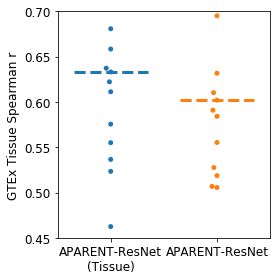

In [6]:
#Compare predictor r-values

import seaborn as sns

f = plt.figure(figsize=(4, 4))

ax = sns.swarmplot(data=[correct_spearman_rs, spearman_rs[:, 0]])

r_medians = [np.median(correct_spearman_rs), np.median(spearman_rs[:, 0])]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, r_m in enumerate(r_medians) :
    plt.plot([i - 0.35, i + 0.35], [r_m, r_m], linewidth=3, linestyle="--", color=colors[i])

plt.xticks([0, 1], ['APARENT-ResNet\n(Tissue)', 'APARENT-ResNet'], fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0.45, .70)

plt.ylabel("GTEx Tissue Spearman r", fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_scaler_swarms" + suffix + "_brain_expanded.png", dpi=300)
plt.savefig("apa_resnet_tissue_scaler_swarms" + suffix + "_brain_expanded.eps")

plt.show()


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


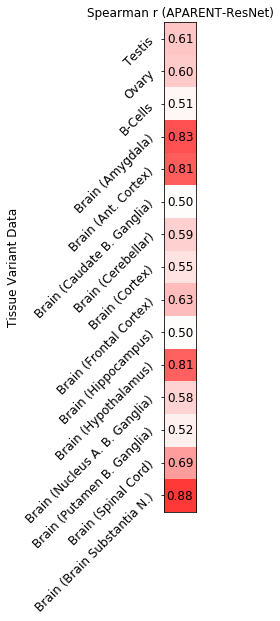

In [7]:

tissues = ['Testis', 'Ovary', 'B-Cells', 'Brain (Amygdala)', 'Brain (Ant. Cortex)', 'Brain (Caudate B. Ganglia)', 'Brain (Cerebellar)', 'Brain (Cortex)', 'Brain (Frontal Cortex)', 'Brain (Hippocampus)', 'Brain (Hypothalamus)', 'Brain (Nucleus A. B. Ganglia)', 'Brain (Putamen B. Ganglia)', 'Brain (Spinal Cord)', 'Brain (Brain Substantia N.)']

f = plt.figure(figsize=(2, 9))

plt.imshow(spearman_rs[:, 0][:, None], cmap="bwr", vmin=0., vmax=1., aspect='equal')

for i in range(spearman_rs.shape[0]) :
    spearm_str = str(spearman_rs[:, 0][:, None][i, 0])[:4]
    text = plt.gca().text(0, i, spearm_str, ha="center", va="center", color="black", fontsize=12)

plt.xticks([], [])
plt.yticks(np.arange(len(tissues)), tissues, fontsize=12, rotation=45)

plt.ylabel("Tissue Variant Data", fontsize=12)

plt.title("Spearman r (APARENT-ResNet)", fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_baseline_heatmap" + suffix + ".png", dpi=300)
plt.savefig("apa_resnet_tissue_baseline_heatmap" + suffix + ".eps")

plt.show()


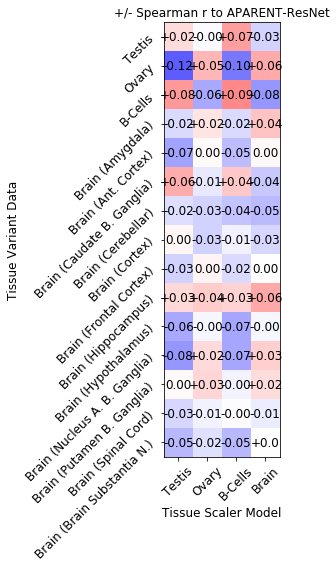

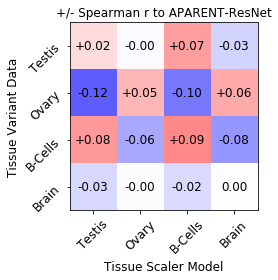

In [8]:
#Expanded Brain Tissues

tissues = ['Testis', 'Ovary', 'B-Cells', 'Brain (Amygdala)', 'Brain (Ant. Cortex)', 'Brain (Caudate B. Ganglia)', 'Brain (Cerebellar)', 'Brain (Cortex)', 'Brain (Frontal Cortex)', 'Brain (Hippocampus)', 'Brain (Hypothalamus)', 'Brain (Nucleus A. B. Ganglia)', 'Brain (Putamen B. Ganglia)', 'Brain (Spinal Cord)', 'Brain (Brain Substantia N.)']
tissues_scalers = ['Testis', 'Ovary', 'B-Cells', 'Brain']

f = plt.figure(figsize=(8, 8))

plt.imshow(spearman_rs[:, 1:] - spearman_rs[:, 0][:, None], cmap="bwr", vmin=-0.2, vmax=0.2, aspect='equal')

for i in range(spearman_rs.shape[0]) :
    for j in range(spearman_rs.shape[1] - 1) :
        
        spearm_str = str((spearman_rs[:, 1:] - spearman_rs[:, 0][:, None])[i, j])[:5]
        spearm_str = "+" + spearm_str[:4] if spearm_str[0] != "-" else spearm_str
        
        spearm_str = spearm_str if str((spearman_rs[:, 1:] - spearman_rs[:, 0][:, None])[i, j])[:4] != "0.00" else spearm_str[1:]
        
        text = plt.gca().text(j, i, spearm_str, ha="center", va="center", color="black", fontsize=12)

plt.xticks(np.arange(len(tissues_scalers)), tissues_scalers, fontsize=12, rotation=45)
plt.yticks(np.arange(len(tissues)), tissues, fontsize=12, rotation=45)

plt.xlabel("Tissue Scaler Model", fontsize=12)
plt.ylabel("Tissue Variant Data", fontsize=12)

plt.title("+/- Spearman r to APARENT-ResNet", fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_scaler_heatmap" + suffix + "_brain_expanded.png", dpi=300)
plt.savefig("apa_resnet_tissue_scaler_heatmap" + suffix + "_brain_expanded.eps")

plt.show()

#Collapsed Brain Tissues

spearman_rs_collapsed = spearman_rs[:, 1:] - spearman_rs[:, 0][:, None]
spearman_rs_collapsed[3:, :] = np.median(spearman_rs_collapsed[3:, :], axis=0)
spearman_rs_collapsed = spearman_rs_collapsed[:4, :]

tissues = ['Testis', 'Ovary', 'B-Cells', 'Brain']
tissues_scalers = ['Testis', 'Ovary', 'B-Cells', 'Brain']

f = plt.figure(figsize=(4, 4))

plt.imshow(spearman_rs_collapsed, cmap="bwr", vmin=-0.2, vmax=0.2, aspect='equal')

for i in range(spearman_rs_collapsed.shape[0]) :
    for j in range(spearman_rs_collapsed.shape[1]) :
        
        spearm_str = str(spearman_rs_collapsed[i, j])[:5]
        spearm_str = "+" + spearm_str[:4] if spearm_str[0] != "-" else spearm_str
        
        spearm_str = spearm_str if str(spearman_rs_collapsed[i, j])[:4] != "0.00" else spearm_str[1:]
        
        text = plt.gca().text(j, i, spearm_str, ha="center", va="center", color="black", fontsize=12)

plt.xticks(np.arange(len(tissues_scalers)), tissues_scalers, fontsize=12, rotation=45)
plt.yticks(np.arange(len(tissues)), tissues, fontsize=12, rotation=45)

plt.xlabel("Tissue Scaler Model", fontsize=12)
plt.ylabel("Tissue Variant Data", fontsize=12)

plt.title("+/- Spearman r to APARENT-ResNet", fontsize=12)

plt.tight_layout()

plt.savefig("apa_resnet_tissue_scaler_heatmap" + suffix + "_brain_collapsed.png", dpi=300)
plt.savefig("apa_resnet_tissue_scaler_heatmap" + suffix + "_brain_collapsed.eps")

plt.show()
